In [364]:
import numpy as np
import os
import pandas as pd
import re
import requests
import kagglehub
import sys
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Machine Learning Project

by Andon Gorchov (@thunderman913)

In [287]:
path = kagglehub.dataset_download("tsaustin/us-historical-stock-prices-with-earnings-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\andon\.cache\kagglehub\datasets\tsaustin\us-historical-stock-prices-with-earnings-data\versions\7


In [288]:
earnings_path = f"{path}\\stocks_latest\\earnings_latest.csv"
stock_prices_path = f"{path}\\stocks_latest\\stock_prices_latest.csv"

In [289]:
earnings_data = pd.read_csv(earnings_path)
stock_data = pd.read_csv(stock_prices_path)

In [290]:
# Function to get the price X days ago
def get_price_x_days_ago(df, days):
    return df['close'].shift(days)

# Function to get peak price and how many days ago it happened
def get_peak_price_and_days_ago(df):
    df['peak_price'] = df['close'].rolling(window=90, min_periods=1).max()
    peak_day_index = df['close'].rolling(window=90, min_periods=1).apply(lambda x: (len(x) - 1 - x.argmax()), raw=False)
    df['peak_days_ago'] = peak_day_index.fillna(0).astype(int)  # Fill NaN for rows that don't have enough data
    return df

# Apply the operations without grouping by ticker
def process_ticker_data(df):
    # Add columns for prices X days ago
    for days in [1,2,3,4,5, 10, 15, 30, 60, 90]:
        df[f'price_{days}_days_ago'] = df.groupby('ticker')['close'].shift(days)
        df[f'volume_{days}_days_ago'] = df.groupby('ticker')['volume'].shift(days)
    
    # Get peak price and peak days ago
    #df = df.groupby('ticker', group_keys=False).apply(get_peak_price_and_days_ago)
    return df

In [291]:
def tidyStockData():
    file_path = 'stock_data_processed.pkl'

    # Check if the file exists
    if os.path.exists(file_path):
        return pd.read_pickle('stock_data_processed.pkl')

    stock_data_tidy = stock_data

    stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)
    stock_data_tidy = stock_data_tidy.rename(columns={'symbol': 'ticker'})
    stock_data_tidy = stock_data_tidy.drop(columns=['split_coefficient'])

    stock_data_tidy = stock_data_tidy[(stock_data_tidy['date'] > (earnings_data_tidy['date'].min() - pd.Timedelta(days=100)))
                                    | (stock_data_tidy['date'] < earnings_data_tidy['date'].max() + pd.Timedelta(days=5))]

    # Sort the DataFrame by ticker and date
    stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'], ascending=[True, True])

    # Process the DataFrame without grouping
    stock_data_tidy = process_ticker_data(stock_data_tidy)

    stock_data_tidy = stock_data_tidy[stock_data_tidy.price_90_days_ago.isna() == False]
    stock_data_tidy.to_pickle('stock_data_processed.pkl')
    
    return stock_data_tidy

In [292]:
stock_data_tidy = tidyStockData()

In [293]:
earnings_data_tidy = earnings_data
earnings_data_tidy.date = pd.to_datetime(earnings_data_tidy.date)

In [294]:
earnings_data_tidy = earnings_data_tidy.rename(columns={'symbol': 'ticker'})

In [295]:
earnings_data_tidy = earnings_data_tidy.drop(earnings_data_tidy[(earnings_data_tidy.eps.isna()) | (earnings_data_tidy.eps_est.isna())].index)
earnings_data_tidy = earnings_data_tidy.drop(columns=['qtr'])

In [296]:
earnings_data_tidy = earnings_data_tidy.rename(columns={'date': 'earnings_date'})

In [297]:
earnings_data_tidy['release_time'] = earnings_data_tidy.groupby('ticker')['release_time'].ffill().bfill()

In [298]:
# Adding earnings data to stock_data_tidy based on the nearest previous date
def add_earnings_data(stock_data, earnings):
    # Merge earnings data and stock data on ticker
    merged_df = pd.merge_asof(
        stock_data.sort_values(by='date'),
        earnings.sort_values(by='earnings_date'),
        by='ticker',
        left_on='date',
        right_on='earnings_date',
        direction='backward'
    )
    
    # Forward fill to ensure non-trading days are adjusted properly
    merged_df = merged_df.sort_values(by=['ticker', 'date'])

    # Merge again to get the next earnings date
    merged_df = pd.merge_asof(
        merged_df.sort_values(by='date'),
        earnings[['ticker', 'earnings_date']].sort_values(by='earnings_date'),
        by='ticker',
        left_on='date',
        right_on='earnings_date',
        direction='forward',
        suffixes=('', '_next'),
        allow_exact_matches=False
    )
    
    return merged_df

# Add earnings data to stock_data_tidy
stock_data_tidy = add_earnings_data(stock_data_tidy, earnings_data_tidy)

In [299]:
earnings_data_tidy[earnings_data_tidy.ticker == 'PAYS']

,ticker,earnings_date,eps_est,eps,release_time
115962,PAYS,2019-05-07,0.020,0.03,pre
115963,PAYS,2019-05-08,0.020,0.03,pre
115964,PAYS,2019-08-06,0.033,0.05,pre
115965,PAYS,2019-11-05,0.040,0.06,post
115966,PAYS,2020-04-03,0.060,0.05,pre
115967,PAYS,2020-08-13,0.035,0.01,post
115968,PAYS,2020-11-17,0.018,-0.14,pre
115969,PAYS,2021-03-25,0.013,0.01,pre
115970,PAYS,2021-05-11,0.013,-0.01,post


In [300]:
stock_data_tidy = stock_data_tidy.drop(stock_data_tidy[(stock_data_tidy.earnings_date.isna()) | (stock_data_tidy.earnings_date_next.isna())].index)

In [301]:
stock_data_tidy['days_till_report'] = (stock_data_tidy['earnings_date_next'] - stock_data_tidy['date']).dt.days
stock_data_tidy['days_since_report'] = (stock_data_tidy['date'] - stock_data_tidy['earnings_date']).dt.days

In [302]:
stock_data_tidy[['ticker','date', 'earnings_date', 'earnings_date_next', 'days_till_report', 'days_since_report']]

,ticker,date,earnings_date,earnings_date_next,days_till_report,days_since_report
0,A,2012-12-26,2012-11-19,2013-02-14,50,37
2,PAR,2012-12-26,2012-11-05,2013-02-14,50,51
3,AIZ,2012-12-26,2012-10-24,2013-02-06,42,63
7,PAYX,2012-12-26,2012-12-19,2013-03-27,91,7
8,PB,2012-12-26,2012-10-24,2013-01-25,30,63
...,...,...,...,...,...,...
11762357,RFIL,2021-06-10,2021-03-11,2021-06-14,4,91
11762404,CODA,2021-06-10,2021-03-17,2021-06-14,4,85
11762995,ADXS,2021-06-11,2020-09-10,2021-06-14,3,274
11764002,RFIL,2021-06-11,2021-03-11,2021-06-14,3,92


We remove data with more than 120 days on both next and previous report, since that is useless data for our case

In [303]:
stock_data_tidy = stock_data_tidy.drop(stock_data_tidy[(stock_data_tidy.days_till_report > 120) & (stock_data_tidy.days_since_report > 120)].index)

In [304]:
stock_data_tidy = stock_data_tidy.drop(columns=['open', 'high', 'low', 'close_adjusted', 'volume'])

In [305]:
le = LabelEncoder()
stock_data_tidy['ticker_encoded'] = le.fit_transform(stock_data_tidy['ticker'])

In [306]:
features = [
    'ticker_encoded', 'peak_price', 'peak_days_ago', 'price_1_days_ago', 'volume_1_days_ago',
    'price_2_days_ago', 'volume_2_days_ago', 'price_3_days_ago', 'volume_3_days_ago',
    'price_4_days_ago', 'volume_4_days_ago', 'price_5_days_ago', 'volume_5_days_ago',
    'price_10_days_ago', 'volume_10_days_ago', 'price_15_days_ago', 'volume_15_days_ago',
    'price_30_days_ago', 'volume_30_days_ago', 'price_60_days_ago', 'volume_60_days_ago',
    'price_90_days_ago', 'volume_90_days_ago', 'eps_est', 'eps', 'days_till_report', 'days_since_report'
]

In [307]:
# Apply a scaler to price-related columns to normalize them
scaler = MinMaxScaler()

price_columns = [
    'peak_price', 'price_1_days_ago', 'price_2_days_ago', 'price_3_days_ago', 'price_4_days_ago',
    'price_5_days_ago', 'price_10_days_ago', 'price_15_days_ago', 'price_30_days_ago',
    'price_60_days_ago', 'price_90_days_ago', 'eps_est', 'eps'
]
target = 'close'

# Drop rows with NaN values in the features or target columns
stock_data_tidy = stock_data_tidy.dropna(subset=features + [target])

# Split the data into 80% for training and 20% for final testing
X = stock_data_tidy[features]
y = stock_data_tidy[target]

X = scaler.fit_transform(X)

X_main, X_final_test, y_main, y_final_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the remaining 80% data into 80% training and 20% validation (i.e., 64% train, 16% validation overall)
X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=0.2, random_state=42)

# Train a RandomForestRegressor model
forest_model = RandomForestRegressor(n_estimators=1, random_state=42)
forest_model.fit(X_train, y_train)

# Score the model on the training data
train_score = forest_model.score(X_train, y_train)
print(f"Training Score: {train_score}")

# Make predictions on the test set
y_pred = forest_model.predict(X_test)

# Calculate and print the mean squared error
mse = np.mean((y_test - y_pred) ** 2)
print(f"Mean Squared Error: {mse}")

Training Score: 0.9999504607977218
Mean Squared Error: 1304.1183162887


In [367]:
train_score = forest_model.score(X_final_test, y_final_test)
print(f"Training Score: {train_score}")

In [309]:
train_score = forest_model.score(X_train, y_train)
print(f"Training Score: {train_score}")

Training Score: 0.9999504607977218


In [310]:
le.inverse_transform([9])

array(['AAPL'], dtype=object)

In [311]:
y_final_test[y_final_test.index == 310322]

310322    426.98
Name: close, dtype: float64

In [312]:
test = pd.DataFrame(X_final_test)
to_predict = test[test.index == 310322]

In [313]:
forest_model.predict(to_predict)

array([87.47])

In [319]:
aapl_data = {
    'ticker': ['AAPL'],
    'date': [pd.to_datetime('2024-05-10')],
    'peak_price': [183.38],  # Example value
    'peak_days_ago': [5],   # Example value
    'price_1_days_ago': [184.57],  # Example value
    'volume_1_days_ago': [48983000],  # Example value
    'price_2_days_ago': [182.74],  # Example value
    'volume_2_days_ago': [45057100],  # Example value
    'price_3_days_ago': [182.40],  # Example value
    'volume_3_days_ago': [77305800],  # Example value
    'price_4_days_ago': [181.71],  # Example value
    'volume_4_days_ago': [78569700],  # Example value
    'price_5_days_ago': [183.38],  # Example value
    'volume_5_days_ago': [163224100],  # Example value
    'price_10_days_ago': [160.89],  # Example value
    'volume_10_days_ago': [65934800],  # Example value
    'price_15_days_ago': [167.04],  # Example value
    'volume_15_days_ago': [49537800],  # Example value
    'price_30_days_ago': [169.24],  # Example value
    'volume_30_days_ago': [91070300],  # Example value
    'price_60_days_ago': [172.75],  # Example value
    'volume_60_days_ago': [60139500],  # Example value
    'price_90_days_ago': [183.86],  # Example value
    'volume_90_days_ago': [65454500],  # Example value
    'eps_est': [1.34],
    'eps': [1.4], 
    'days_till_report': [89],
    'days_since_report': [5],
    'ticker_encoded': [5]
}

# Convert to DataFrame
aapl_df = pd.DataFrame(aapl_data)

price_columns = [
    'peak_price', 'price_1_days_ago', 'price_2_days_ago', 'price_3_days_ago', 'price_4_days_ago',
    'price_5_days_ago', 'price_10_days_ago', 'price_15_days_ago', 'price_30_days_ago',
    'price_60_days_ago', 'price_90_days_ago', 'eps_est', 'eps'
]

# Fit and transform the price-related columns
aapl_df[price_columns] = scaler.fit_transform(aapl_df[price_columns])


# Predict the closing price
aapl_features = aapl_df[features]
predicted_close = forest_model.predict(aapl_features)

print(f"Predicted closing price for AAPL on May 10, 2024: {[y_pred]}")

Predicted closing price for AAPL on May 10, 2024: [array([183.38, 183.38, 183.38, ..., 183.38, 183.38, 183.38])]


C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [321]:
predicted_close[0]

np.float64(1.92)

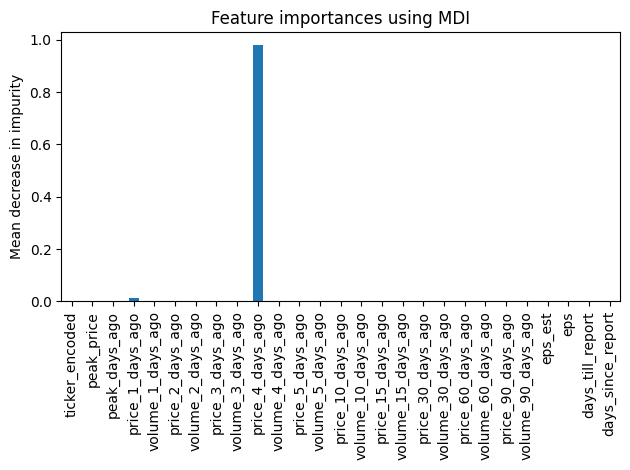

In [322]:
std = np.std([tree.feature_importances_ for tree in forest_model.estimators_], axis=0)

importances = forest_model.feature_importances_
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Training Score: 0.9999340079779602
Mean Squared Error: 8333494.033319481


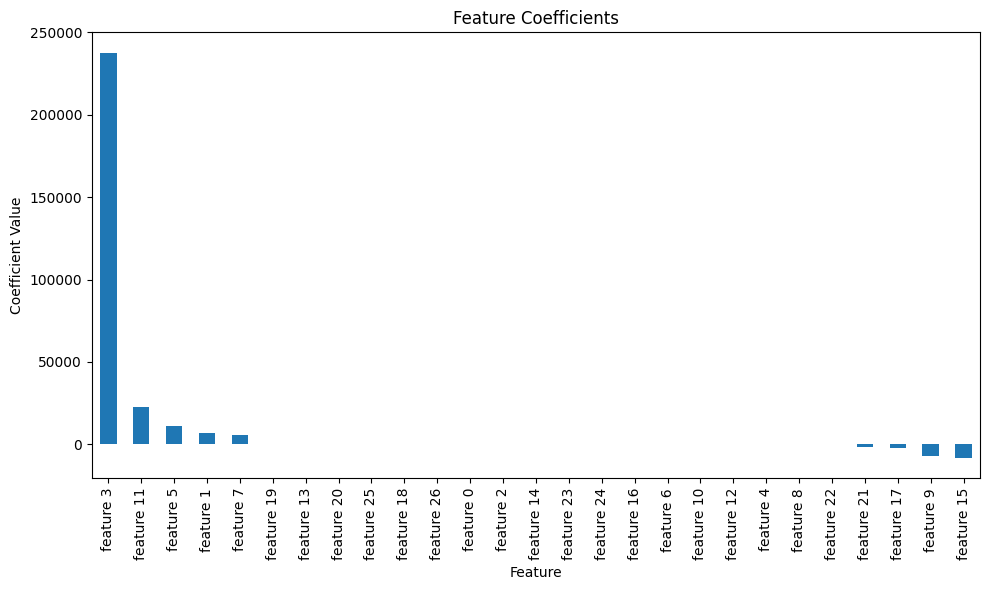

In [325]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Score the model on the training data
train_score = linear_model.score(X_train, y_train)
print(f"Training Score: {train_score}")

# Make predictions on the test set
y_pred_scaled = linear_model.predict(X_test)

# Inverse transform the predictions to convert back to actual prices
y_pred = y_pred_scaled * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

# Calculate and print the mean squared error
mse = np.mean((y_test - y_pred) ** 2)
print(f"Mean Squared Error: {mse}")

# Linear regression does not provide feature importances in the same way as RandomForest
# Instead, we can look at the coefficients
coefficients = pd.Series(linear_model.coef_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar')
plt.title('Feature Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [326]:
train_score = linear_model.score(X_final_test, y_final_test)
print(f"Training Score: {train_score}")

Training Score: 0.9999007040346868


27

In [355]:
X_final_test[1].__len__()
predicted_close = linear_model.predict(X_final_test[1306716].reshape(1,-1))
predicted_close

array([128.4002134])

In [347]:
y_final_test

2104983      11.16
8425994       6.25
3930903      12.32
313824       86.38
7315858      60.65
             ...  
11549401     87.31
2077750     124.95
6411334       2.19
10796317      6.45
6562787     156.38
Name: close, Length: 1306720, dtype: float64

In [362]:
forest_model.score(X_final_test, y_final_test)

0.9997892571422367

In [359]:
X_final_test[1].__len__()
predicted_close = forest_model.predict(X_final_test[1306719].reshape(1,-1))
predicted_close

array([156.47])

In [369]:
stock_data_tidy.close.mean()

np.float64(79.27421331343209)

In [368]:
from sklearn.metrics import mean_absolute_error

# Calculate MSE (Lower better)
mse = mean_squared_error(y_test, y_pred)
print("MSE of testing set:", mse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE of testing set:", mae)

# Calculate RMSE (Lower better)
rmse = np.sqrt(mse)
print("RMSE of testing set:", rmse)

MSE of testing set: 1304.1183162887
MAE of testing set: 1.2342498383356797
RMSE of testing set: 36.11257836666748


In [377]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

param_distributions = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                   param_distributions=param_distributions,
                                   n_iter=5, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train[:10000], y_train[:10000])
forest_model = random_search.best_estimator_


Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [381]:
forest_model

RandomForestRegressor(max_depth=30, n_estimators=500, random_state=42)

In [382]:
forest_model.score(X_train, y_train)

0.9923147943983335